# Regresión logística

Vamos a aplicar los conceptos aprendidos en la teoría sobre el modelo de regresión logística, usamos la clase implementada en `sklearn` y en `statsmodels`.

# Importaciones

In [1]:
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Leemos los conjuntos de datos

Vamos a usar el conjunto de datos del [Titanic](https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv). En concreto, vamos a crear un modelo capaz de predecir si la persona sobrevivió al hundimiento del Titanic en función del sexo (`sex`), de la edad (`age`) y de la ciudad de embarcación (`embark_town`). 

In [2]:
data = pd.read_csv("./datos/titanic.csv")
data = data[["survived", "pclass", "sex", "age", "embark_town"]]
data = data.dropna()
del data['pclass']

X = data.loc[:,data.columns != 'survived']
y = data.loc[:,data.columns == 'survived']

s = pd.get_dummies(X)
del s['sex_female']
del s['embark_town_Cherbourg']

In [3]:
X

sex   age  embark_town
0      male  22.0  Southampton
1    female  38.0    Cherbourg
2    female  26.0  Southampton
3    female  35.0  Southampton
4      male  35.0  Southampton
..      ...   ...          ...
885  female  39.0   Queenstown
886    male  27.0  Southampton
887  female  19.0  Southampton
889    male  26.0    Cherbourg
890    male  32.0   Queenstown

[712 rows x 3 columns]

## Modelo de regresión logística

En `statmodels` la regresión logística se hace con `logit`. Como siempre, debemos especificar la fórmula y los datos asociados. La propia función hace automáticamente las dummy asociadas.

In [4]:
log_reg = smf.logit(formula = "survived ~ sex + age + embark_town", data=data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.509889
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      707
Method:                           MLE   Df Model:                            4
Date:                Sat, 20 Jan 2024   Pseudo R-squ.:                  0.2444
Time:                        15:58:21   Log-Likelihood:                -363.04
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 1.209e-49
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      2.2046      0.322      6.851      0.000       1.574       2.835
sex[T.male]                   -2.4760      0.191    -12.976      0.000      -2.850      -2.102
embark_town[T.Queenstown]     -1.8156      0.535     -3.393      0.001      -2.864      -0.767
embark_town[T.Southampton]    -1.0069      0.237     -4.251      0.000      -1.471      -0.543
age                           -0.0081      0.007     -1.233      0.217      -0.021       0.005
==============================================================================================
"""

Por defecto `sklearn` aplica una regularización a los parámetros del modelo, que veremos más adelante. para observar que nos dén los mismos resultados, la vamos a deshabilitar a través del argumento `penalty='none'`.

In [8]:
rl = LogisticRegression(penalty=None)
rl.fit(s, np.ravel(y))
pd.DataFrame({'Coeficientes':rl.feature_names_in_, 'Estimadores':rl.coef_[0]})

Coeficientes  Estimadores
0                      age    -0.008078
1                 sex_male    -2.475953
2   embark_town_Queenstown    -1.815557
3  embark_town_Southampton    -1.006956

## Matriz de confusión

`sklearn` ya tiene implementado un método con el que calcular la matriz de confusión. En este caso, como vamos a aplicar un clasificador de bayes, todos aquellas probabilidades que sean superiores a 0.5, serán de la clase 1 (habrán sobrevivido) mientras que aquellas que sean menores tendrán la clase 0.

In [6]:
y_pred_proba = log_reg.predict(data)
confusion_matrix(y, y_pred_proba > 0.5)

array([[360,  64],
       [ 93, 195]], dtype=int64)

## Curva ROC

Para obtener la curva, primero deberemos calcular los valores de la curva, con `roc_curve`. Después, con `roc_auc_score` obtenemos el área bajo la curva que nos ayudará a obtener la medida de bondad del modelo. 

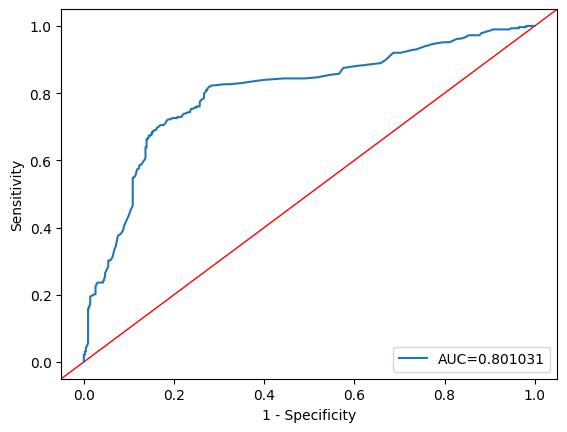

In [7]:
y_pred_proba = log_reg.predict(data)
spe, sens, _ = metrics.roc_curve(y,  y_pred_proba)
auc = metrics.roc_auc_score(y, y_pred_proba)

plt.axline((0, 0), (1, 1), linewidth=1, color='r')
plt.plot(spe,sens,label="AUC="+str(round(auc,6)))
plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
plt.legend(loc=4)
plt.show()